In [2]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from math import sqrt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

2024-02-27 19:11:41.765795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

In [ ]:


batch_size = 32  # This is the number of samples per gradient update.
time_steps = 100  # This is the 'window' of time steps you're looking at to predict the next step.
features = 1  # For univariate data, the number of features is 1.

model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, stateful=True, batch_input_shape=(batch_size, time_steps, features)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=True, stateful=True),
    Dropout(0.2),
    LSTM(50, activation='relu', stateful=True),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# USDC Univariate LSTM Time Series

Approximately 2,000 samples

In [39]:
def json_to_prices(json):
    df = pd.read_json(json)
    prices = df['prices']
    coin_prices = pd.DataFrame(prices.tolist(), columns=['time', 'price'])
    prices = coin_prices['price']
    return prices

In [40]:
# only read prices from usdc90days.json 
# df = pd.read_json('usdc90days.json')
json_to_prices('usdc90days.json')

0       1.0003
1       0.9999
2       0.9994
3       1.0000
4       0.9989
         ...  
2155    0.9974
2156    1.0000
2157    1.0005
2158    0.9987
2159    1.0001
Name: price, Length: 2160, dtype: float64

In [6]:
df.head()

,prices,market_caps,total_volumes
0,"[1701295258512, 1.0003]","[1701295258512, 24513046144.558582]","[1701295258512, 6983029033.137979]"
1,"[1701298861040, 0.9999]","[1701298861040, 24471127474.82831]","[1701298861040, 6386641883.446817]"
2,"[1701302432646, 0.9994000000000001]","[1701302432646, 24430396390.51601]","[1701302432646, 7485297471.84702]"
3,"[1701306011923, 1]","[1701306011923, 24439466807.527813]","[1701306011923, 7142327551.102169]"
4,"[1701309615019, 0.9989]","[1701309615019, 24436036853.94362]","[1701309615019, 7119370674.790359]"


In [14]:
# extract onnly price column
prices = df['prices']
prices.head()
usdc_prices = pd.DataFrame(prices.tolist(), columns=['time', 'price'])
usdc_prices.head()

prices = usdc_prices['price']
print(prices)

0       1.0003
1       0.9999
2       0.9994
3       1.0000
4       0.9989
         ...  
2155    0.9974
2156    1.0000
2157    1.0005
2158    0.9987
2159    1.0001
Name: price, Length: 2160, dtype: float64


In [31]:
def normalize_prices(prices):
    normalized_prices = (prices - np.mean(prices)) / np.std(prices)
    return normalized_prices

In [15]:
# Normalize the prices data
normalized_prices = (prices - np.mean(prices)) / np.std(prices)
print(normalized_prices)

0       0.313974
1      -0.139964
2      -0.707387
3      -0.026480
4      -1.274809
          ...   
2155   -2.977077
2156   -0.026480
2157    0.540943
2158   -1.501778
2159    0.087005
Name: price, Length: 2160, dtype: float64


In [43]:
def create_dataset_helper(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

In [30]:
def split_data(data, train_size=0.8):
    train_size = int(len(data) * train_size)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

def create_dataset(data, time_steps=1):
    X, y = create_dataset_helper(data, time_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, y

In [24]:
time_step = 10 # This is the number of time steps you're looking at to predict the next step.
X, y = create_dataset(normalized_prices, time_step)
X = X.reshape(X.shape[0], time_step, 1)

In [25]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [41]:
def create_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [26]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/100
54/54 [==============================] - 4s 20ms/step - loss: 0.9119 - val_loss: 1.3812
Epoch 2/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9106 - val_loss: 1.3644
Epoch 3/100
54/54 [==============================] - 0s 9ms/step - loss: 0.9117 - val_loss: 1.3614
Epoch 4/100
54/54 [==============================] - 0s 8ms/step - loss: 0.9091 - val_loss: 1.3735
Epoch 5/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9091 - val_loss: 1.3674
Epoch 6/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9091 - val_loss: 1.3711
Epoch 7/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9089 - val_loss: 1.3667
Epoch 8/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9090 - val_loss: 1.3643
Epoch 9/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9086 - val_loss: 1.3690
Epoch 10/100
54/54 [==============================] - 0s 7ms/step - loss: 0.9088 - val_loss: 1.3711
Epoch 11

In [49]:
def predictions(model, X_train, y_train, X_test, y_test, prices):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    # invert predictions
    train_predict = (train_predictions * np.std(prices)) + np.mean(prices)
    y_train = (y_train * np.std(prices)) + np.mean(prices)
    test_predict = (test_predictions * np.std(prices)) + np.mean(prices)
    y_test = (y_test * np.std(prices)) + np.mean(prices)
    
    #  calculate root mean squared error
    train_score = sqrt(mean_squared_error(y_train, train_predict))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = sqrt(mean_squared_error(y_test, test_predict))
    print('Test Score: %.2f RMSE' % (test_score))
    

In [22]:
# test the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# invert predictions since we normalized it
train_predict = (train_predict * np.std(prices)) + np.mean(prices)
y_train = (y_train * np.std(prices)) + np.mean(prices)
test_predict = (test_predict * np.std(prices)) + np.mean(prices)
y_test = (y_test * np.std(prices)) + np.mean(prices)

# calculate root mean squared error
train_score = sqrt(mean_squared_error(y_train, train_predict))
print('Train Score: %.2f RMSE' % (train_score))
test_score = sqrt(mean_squared_error(y_test, test_predict))
print('Test Score: %.2f RMSE' % (test_score))



14/14 [==============================] - 0s 2ms/step
Train Score: 0.00 RMSE
Test Score: 0.00 RMSE


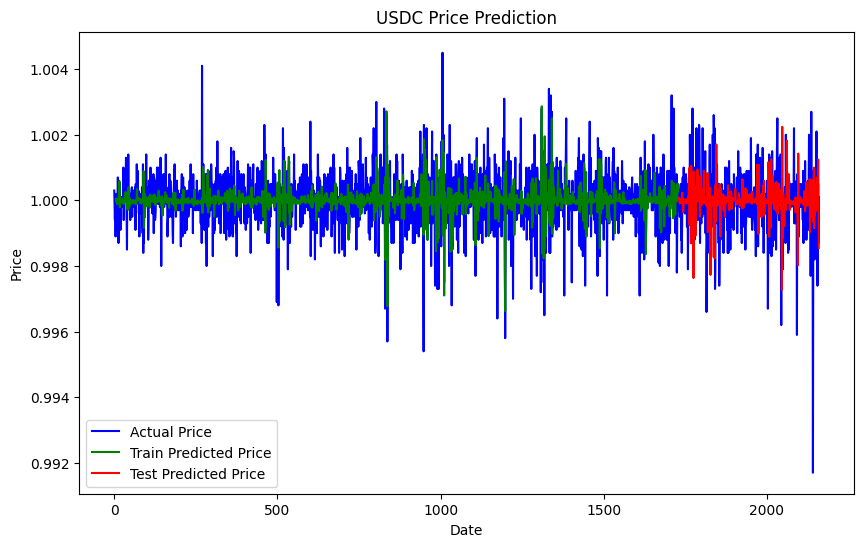

In [23]:
# graph the results
plt.figure(figsize=(10, 6))
plt.plot(prices, color='blue', label='Actual Price')
plt.plot(range(time_step, train_size + time_step), train_predict, color='green', label='Train Predicted Price')
plt.plot(range(train_size + time_step, len(prices)), test_predict, color='red', label='Test Predicted Price')

plt.title('USDC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Ethereum Univariate LSTM Time Series

In [44]:
time_step = 10

prices = json_to_prices('usdc90days.json')
normalized_prices = normalize_prices(prices)
X, y = create_dataset(normalized_prices, time_step)
X_train, x_test = split_data(X)
y_train, y_test = split_data(y)

lstm = create_model()

lstm.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/100
54/54 [==============================] - 5s 29ms/step - loss: 0.9152 - val_loss: 1.3652
Epoch 2/100
54/54 [==============================] - 1s 12ms/step - loss: 0.9102 - val_loss: 1.3628
Epoch 3/100
54/54 [==============================] - 1s 12ms/step - loss: 0.9106 - val_loss: 1.3718
Epoch 4/100
54/54 [==============================] - 1s 12ms/step - loss: 0.9108 - val_loss: 1.3667
Epoch 5/100
54/54 [==============================] - 1s 11ms/step - loss: 0.9104 - val_loss: 1.3660
Epoch 6/100
54/54 [==============================] - 1s 11ms/step - loss: 0.9102 - val_loss: 1.3702
Epoch 7/100
54/54 [==============================] - 1s 11ms/step - loss: 0.9112 - val_loss: 1.3698
Epoch 8/100
54/54 [==============================] - 1s 11ms/step - loss: 0.9106 - val_loss: 1.3678
Epoch 9/100
54/54 [==============================] - 1s 13ms/step - loss: 0.9088 - val_loss: 1.3603
Epoch 10/100
54/54 [==============================] - 1s 12ms/step - loss: 0.9088 - val_loss: 1.3622

In [50]:
predictions(lstm, X_train, y_train, X_test, y_test, prices)

14/14 [==============================] - 0s 3ms/step
Train Score: 0.00 RMSE
Test Score: 0.00 RMSE
